In [1]:
import numpy as np
import datetime
import os
import sys, imp
import regions
import warnings
import glob
from astropy.io import fits
from astropy.table import Table
from astropy import stats
from astropy.wcs import WCS
from astropy import coordinates
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u

try:
    from photutils.apeture import CircularAnnulus, CircularAperture
    from photutils.psf import EPSFBuilder
    from photutils.detection import find_peaks
except ImportError:
    from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

import dust_extinction
from dust_extinction.parameter_averages import CCM89
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC

import PIL
import pyavm

import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['figure.dpi'] = 100
pl.rcParams['font.size'] = 16


/scratch/local/33675441/ipykernel_449465/3000585905.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import sys, imp
/scratch/local/33675441/ipykernel_449465/3000585905.py:24: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/33675441/ipykernel_449465/3000585905.py:24: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will be removed in the future. Instead, please use `from photutils.psf import EPSFBuilder` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/3

In [2]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [3]:
import sys
sys.path.append(f'{basepath}/reduction/')

from make_merged_psf import load_psfgrid, save_psfgrid, make_merged_psf
from webbpsf.utils import to_griddedpsfmodel
import webbpsf

In [5]:
project_id = '2221'
obs_id = '001'
oversampling = 1
filtername = 'f410m'
blur = '_blur'
filename = f'{basepath}/psfs/{filtername.upper()}_{project_id}_{obs_id}_merged_PSFgrid_oversample{oversampling}{blur}.fits'
fh = fits.open(filename)
griddedpsf = to_griddedpsfmodel(filename)

## Simple check: Do the PSFs look right?

6/26/24: these are even-sized grids with a peak at 50,50.  So they're technically halfpixel off-center.

(50, 50)

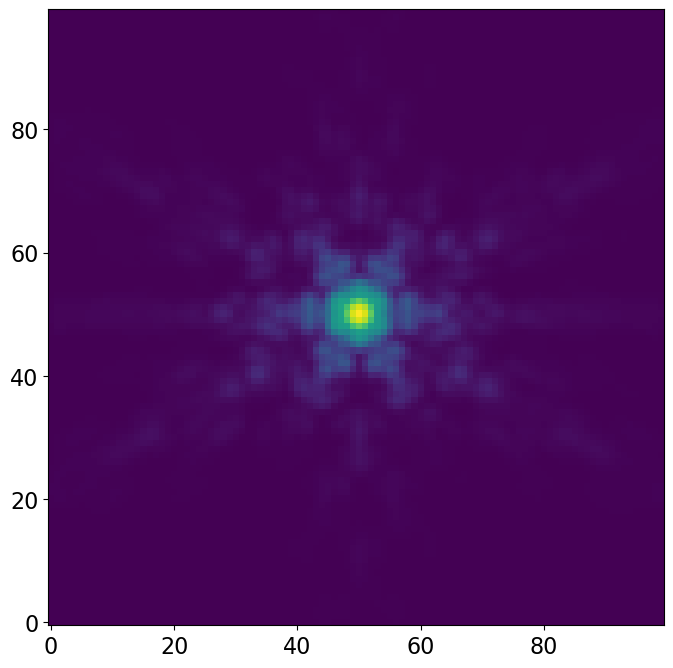

In [6]:
blur = '_blur'
filename = f'{basepath}/psfs/{filtername.upper()}_{project_id}_{obs_id}_merged_PSFgrid_oversample{oversampling}{blur}.fits'
fh = fits.open(filename)
pl.imshow(fh[0].data[0,:,:], norm=simple_norm(fh[0].data[0,:,:], stretch='log'))
np.unravel_index(np.argmax(fh[0].data[0,:,:]), fh[0].data.shape[1:])

(50, 50)

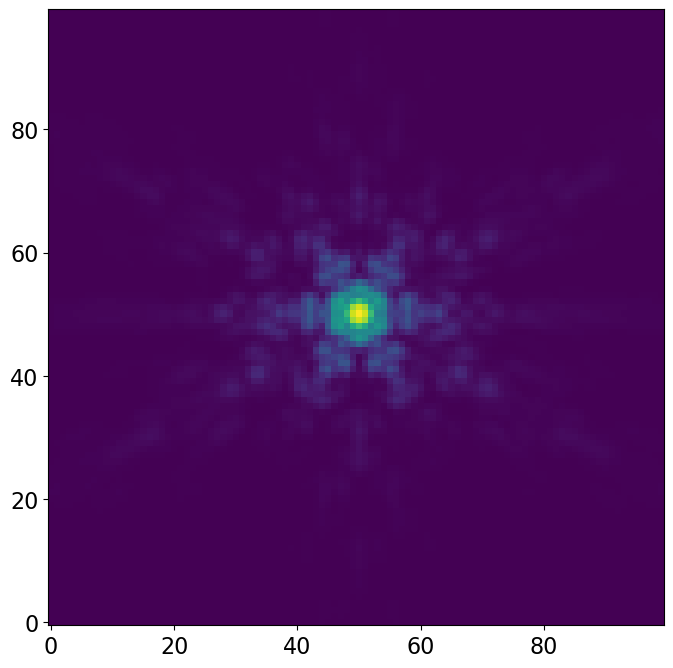

In [7]:
blur=''
filename = f'{basepath}/psfs/{filtername.upper()}_{project_id}_{obs_id}_merged_PSFgrid_oversample{oversampling}{blur}.fits'
fh = fits.open(filename)
pl.imshow(fh[0].data[0,:,:], norm=simple_norm(fh[0].data[0,:,:], stretch='log'))
np.unravel_index(np.argmax(fh[0].data[0,:,:]), fh[0].data.shape[1:])

(50, 50)

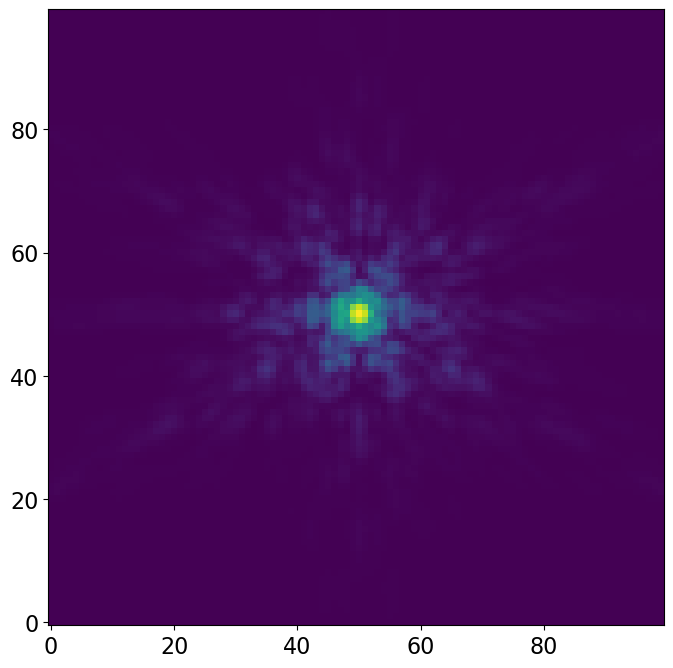

In [8]:
blur = '_blur'
filtername = 'f182m'
filename = f'{basepath}/psfs/{filtername.upper()}_{project_id}_{obs_id}_merged_PSFgrid_oversample{oversampling}{blur}.fits'
fh = fits.open(filename)
pl.imshow(fh[0].data[0,:,:], norm=simple_norm(fh[0].data[0,:,:], stretch='log'))
np.unravel_index(np.argmax(fh[0].data[0,:,:]), fh[0].data.shape[1:])

(50, 50)

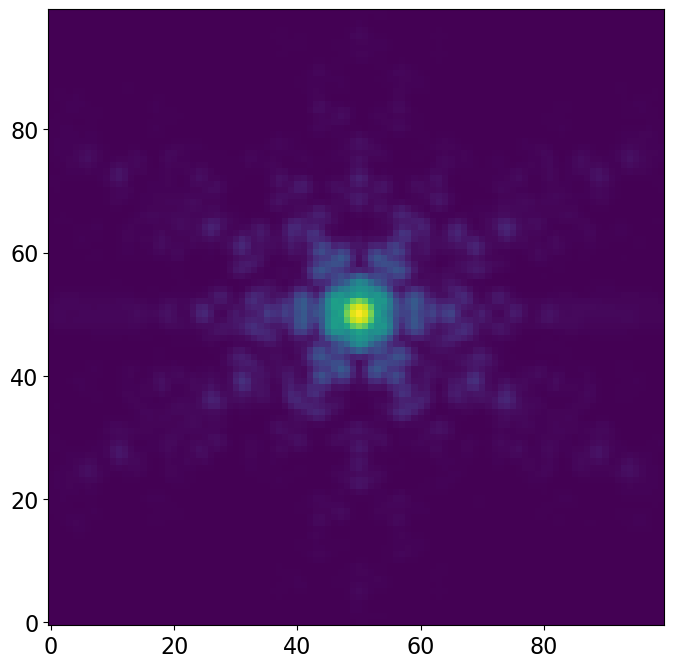

In [9]:
blur = '_blur'
filtername = 'f466n'
filename = f'{basepath}/psfs/{filtername.upper()}_{project_id}_{obs_id}_merged_PSFgrid_oversample{oversampling}{blur}.fits'
fh = fits.open(filename)
pl.imshow(fh[0].data[0,:,:], norm=simple_norm(fh[0].data[0,:,:], stretch='log'))
np.unravel_index(np.argmax(fh[0].data[0,:,:]), fh[0].data.shape[1:])

## Debug work: check that everything behaves as expected

6/26/2024: worried that even-size PSFs with a single-pixel peak were driving systematic shifts.

Updated code to force odd shapes

In [24]:
import importlib
import make_merged_psf
importlib.reload(make_merged_psf)
from make_merged_psf import load_psfgrid, save_psfgrid, make_merged_psf

In [27]:
halfstampsize = 25
grid_step = 2000
oversampling = 1
psfg = make_merged_psf(filtername.upper(),
                       basepath=basepath,
                       halfstampsize=halfstampsize,
                       grid_step=grid_step,
                       oversampling=oversampling,
                       blur=True,
                       project_id=project_id, obs_id=obs_id, suffix='merged_i2d')

Set DATE-AVG to '2022-08-28T02:01:42.906' from MJD-AVG.
Set DATE-END to '2022-08-28T02:29:48.969' from MJD-END'. [astropy.wcs.wcs]
2024-06-26 15:17:14,695 - stpipe - WARNING - FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T01:35:35.416' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:42.906' from MJD-AVG.
Set DATE-END to '2022-08-28T02:29:48.969' from MJD-END'.
Set OBSGEO-B to   -20.693175 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526785127.355 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-06-26 15:17:14,714 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.559692 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.693175 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526785127.355 from OBSGEO-[XYZ]'.


  0%|          | 0/6 [00:00<?, ?it/s]

/orange/adamginsburg/jwst/brick//reduction/make_merged_psf.py:125: RuntimeWarning: invalid value encountered in divide
  cdata = allpsfs / allpsfs.sum(axis=(1,2))[:,None,None]


In [28]:
psfg.data.shape

(6, 51, 51)

(25, 25)

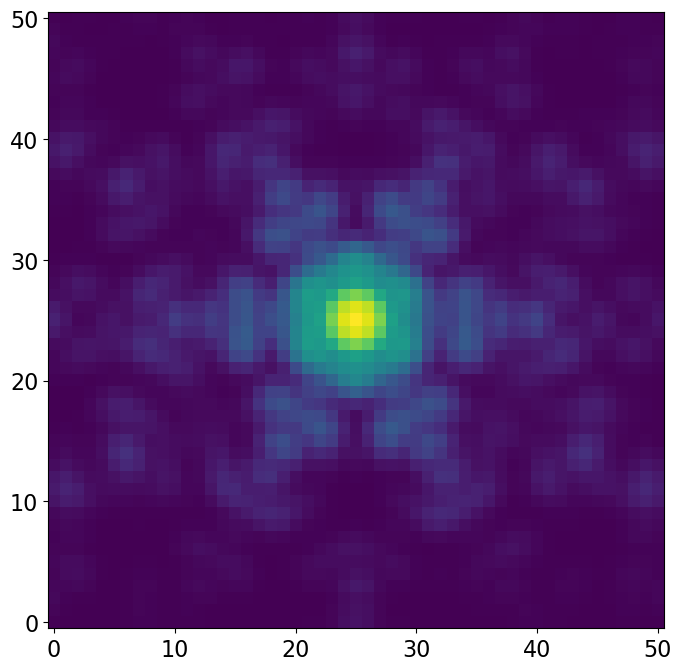

In [33]:
pl.imshow(psfg.data[0,:,:], norm=simple_norm(psfg.data[0,:,:], stretch='log'))
np.unravel_index(np.argmax(psfg.data[0,:,:]), psfg.data.shape[1:])

In [34]:
halfstampsize = 25
grid_step = 2000
oversampling = 2
psfg_2 = make_merged_psf(filtername.upper(),
                         basepath=basepath,
                         halfstampsize=halfstampsize,
                         grid_step=grid_step,
                         oversampling=oversampling,
                         blur=True,
                         project_id=project_id, obs_id=obs_id, suffix='merged_i2d')

Set DATE-AVG to '2022-08-28T02:01:42.906' from MJD-AVG.
Set DATE-END to '2022-08-28T02:29:48.969' from MJD-END'. [astropy.wcs.wcs]
2024-06-26 15:31:39,808 - stpipe - WARNING - FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T01:35:35.416' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:42.906' from MJD-AVG.
Set DATE-END to '2022-08-28T02:29:48.969' from MJD-END'.
Set OBSGEO-B to   -20.693175 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526785127.355 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-06-26 15:31:39,824 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.559692 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.693175 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526785127.355 from OBSGEO-[XYZ]'.


  0%|          | 0/6 [00:00<?, ?it/s]

/orange/adamginsburg/jwst/brick//reduction/make_merged_psf.py:125: RuntimeWarning: invalid value encountered in divide
  cdata = allpsfs / allpsfs.sum(axis=(1,2))[:,None,None]


In [36]:
psfg_2.data.shape

(6, 101, 101)

(50, 50)

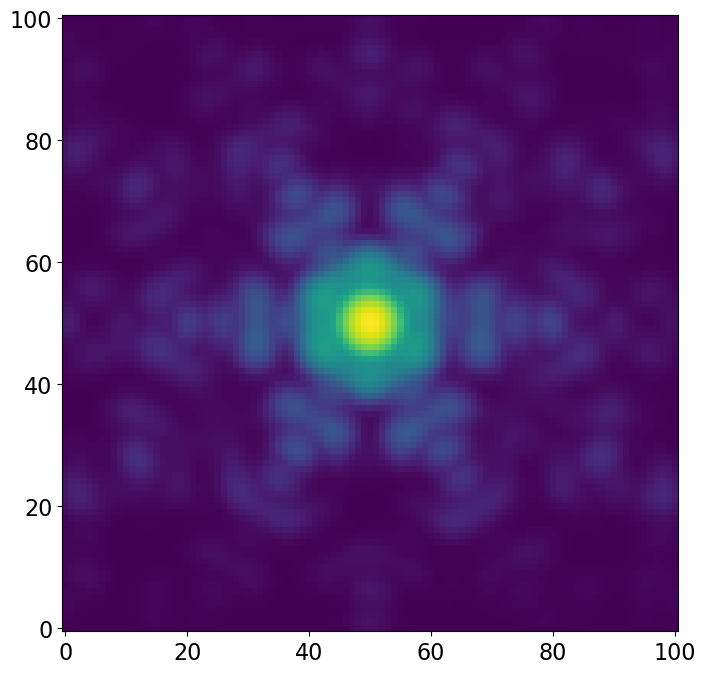

In [38]:
pl.imshow(psfg_2.data[0,:,:], norm=simple_norm(psfg_2.data[0,:,:], stretch='log'))
np.unravel_index(np.argmax(psfg_2.data[0,:,:]), psfg_2.data.shape[1:])

# Roundtrip test of PSF

6/27/2024:

Round-tripping works well for the same PSF.   Using a too-sharp PSF results

In [ ]:
import sys
sys.path.append(f'{basepath}/reduction/')
sys.path.append(f'{basepath}/analysis/')

In [145]:
import importlib
import crowdsource_catalogs_long
importlib.reload(crowdsource_catalogs_long)
from crowdsource_catalogs_long import WrappedPSFModel, get_psf_model, fit_im, catalog_zoom_diagnostic

2024-06-27T14:48:10.605934: Starting crowdsource_catalogs_long
2024-06-27T14:48:10.608463: Importing webbpsf
2024-06-27T14:48:10.609226: Done with imports


Peak pixel is (25, 25)


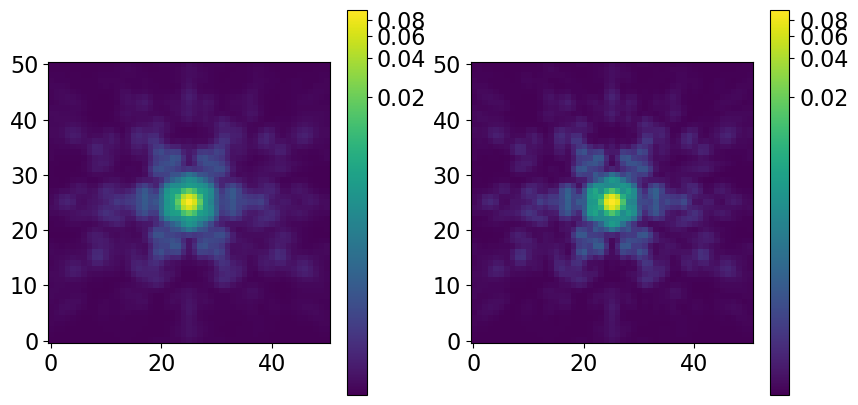

In [137]:
grid_, psf_for_crowdsource = get_psf_model(filtername='f410m', proposal_id='2221', field='001', stampsz=51, blur=False)
grid_, psf_for_crowdsource_blur = get_psf_model(filtername='f410m', proposal_id='2221', field='001', stampsz=51, blur=True)
im = psf_for_crowdsource_blur(25, 25)
pl.figure(figsize=(10,5))
mappable = pl.subplot(1,2,1).imshow(im, norm=simple_norm(im, stretch='log'));
pl.colorbar(mappable);
mappable = pl.subplot(1,2,2).imshow(psf_for_crowdsource(25, 25), norm=simple_norm(im, stretch='log'));
pl.colorbar(mappable);
print(f'Peak pixel is {np.unravel_index(np.argmax(im), im.shape)}')

## Experiment 1: Fit blurred with unblurred, high S/N


Only one star this time (good).  87% flux recovery.

In [132]:
# tried to recover more flux by forcing PSF footprint larger by increasing weight
# https://github.com/schlafly/crowdsource/blob/005276823d0ef183bcd5faa020b0a10c9870cb41/crowdsource/crowdsource_base.py#L580
# code suggests that >1000 S/N should result in 59 pixel sz, but doesn't seem to

# Experiment 1: Fit blur with unblur
im = psf_for_crowdsource_blur(25, 25)
stars, modsky_, skymsky_, psf_ = fit_im(im, psf=psf_for_crowdsource, weight=np.ones_like(im) * 20001 / im.max())

#crowdsource backward [this is modified in save_crowdsource_results]
stars['x'], stars['y'] = stars['y'], stars['x']
Table(stars)

x,y,flux,passno,dx,dy,dflux,qf,rchi2,fracflux,fluxlbs,dfluxlbs,fwhm,spread_model,dspread_model,fluxiso,xiso,yiso,sky
float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32
24.99573532762442,24.99573532762442,0.8727843,0.0,4.2012187e-05,4.177951e-05,2.063902e-05,1.0,861311.7284807168,0.99999994,0.8665357,2.3006214e-05,2.8860636,0.005589027771609301,1.1123438360038486e-06,0.80419254,-5.253652914766513e-05,-2.516365367706956e-05,4.7061694e-05


2024-06-27T14:39:04.114879: -0.009742065177626519 False <astropy.visualization.mpl_normalize.ImageNormalize object at 0x1549d52c2830>


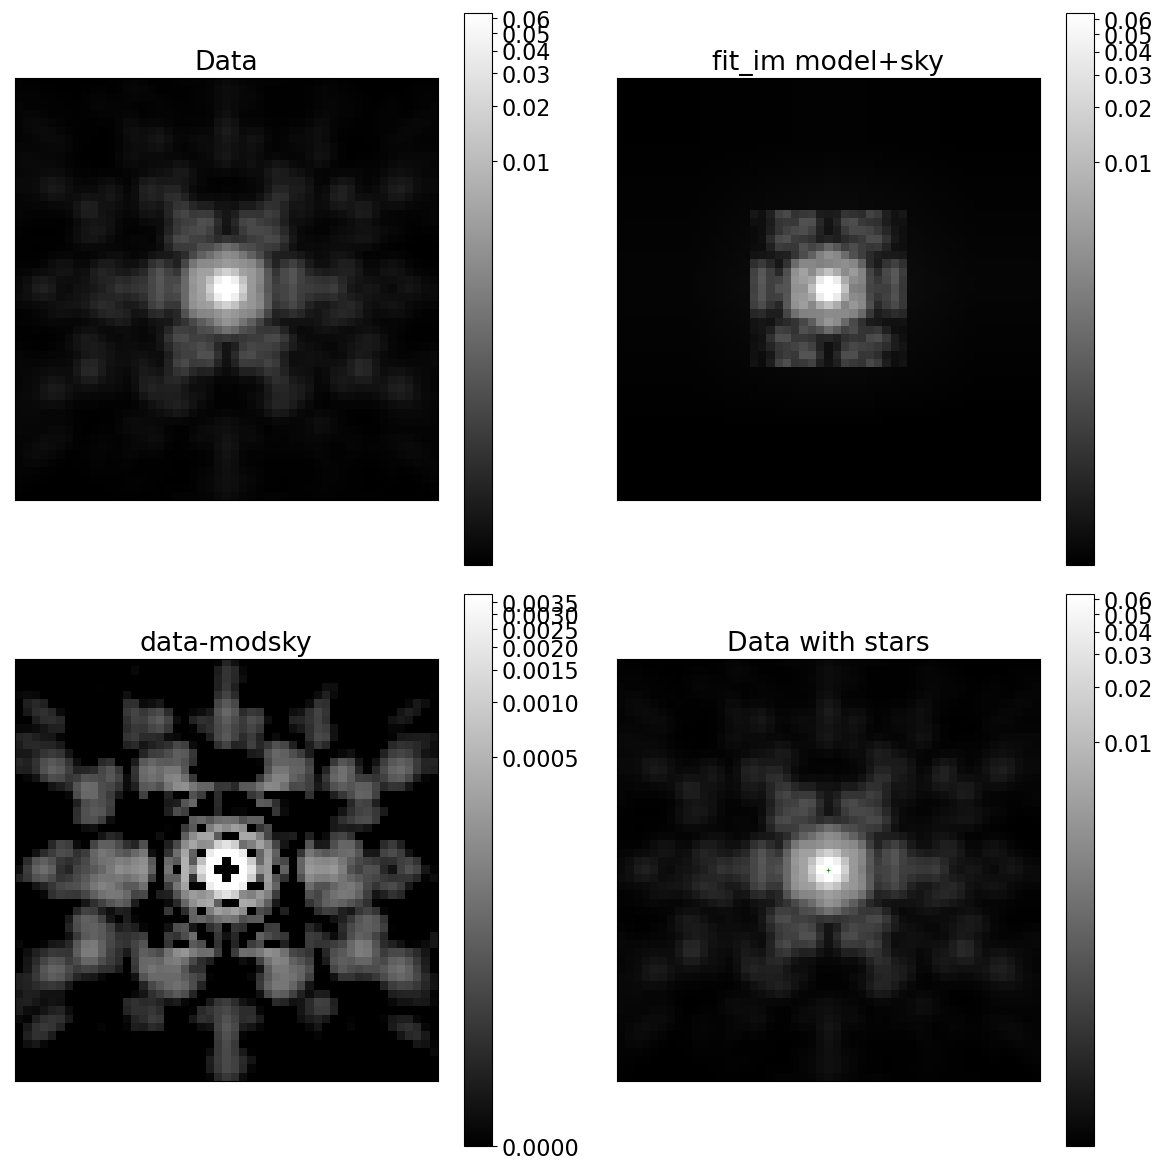

In [133]:
catalog_zoom_diagnostic(im, modsky_, (slice(None), slice(None)), Table(stars))

## Experiment 2: Fit blurred with blurred, high S/N

One source, 99% flux recovery.

In [134]:
# Experiment 2
im = psf_for_crowdsource_blur(25, 25)
stars, modsky_, skymsky_, psf_ = fit_im(im, psf=psf_for_crowdsource_blur, weight=np.ones_like(im) * 20001 / im.max())

#crowdsource backward [this is modified in save_crowdsource_results]
stars['x'], stars['y'] = stars['y'], stars['x']
Table(stars)

x,y,flux,passno,dx,dy,dflux,qf,rchi2,fracflux,fluxlbs,dfluxlbs,fwhm,spread_model,dspread_model,fluxiso,xiso,yiso,sky
float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32
25.00017702105824,25.00017702105824,0.9999444,0.0,4.5474895e-05,4.5438974e-05,2.3404677e-05,1.0,0.48228246802894764,1.0,1.0001268,2.631567e-05,3.2728002,-3.588682225275086e-06,1.1222723667687076e-06,0.9206836,3.3350547449678585e-07,1.740242727856253e-05,5.139913e-07


2024-06-27T14:39:24.046001: -1.693030794898375e-05 False <astropy.visualization.mpl_normalize.ImageNormalize object at 0x1549cf4aa2f0>


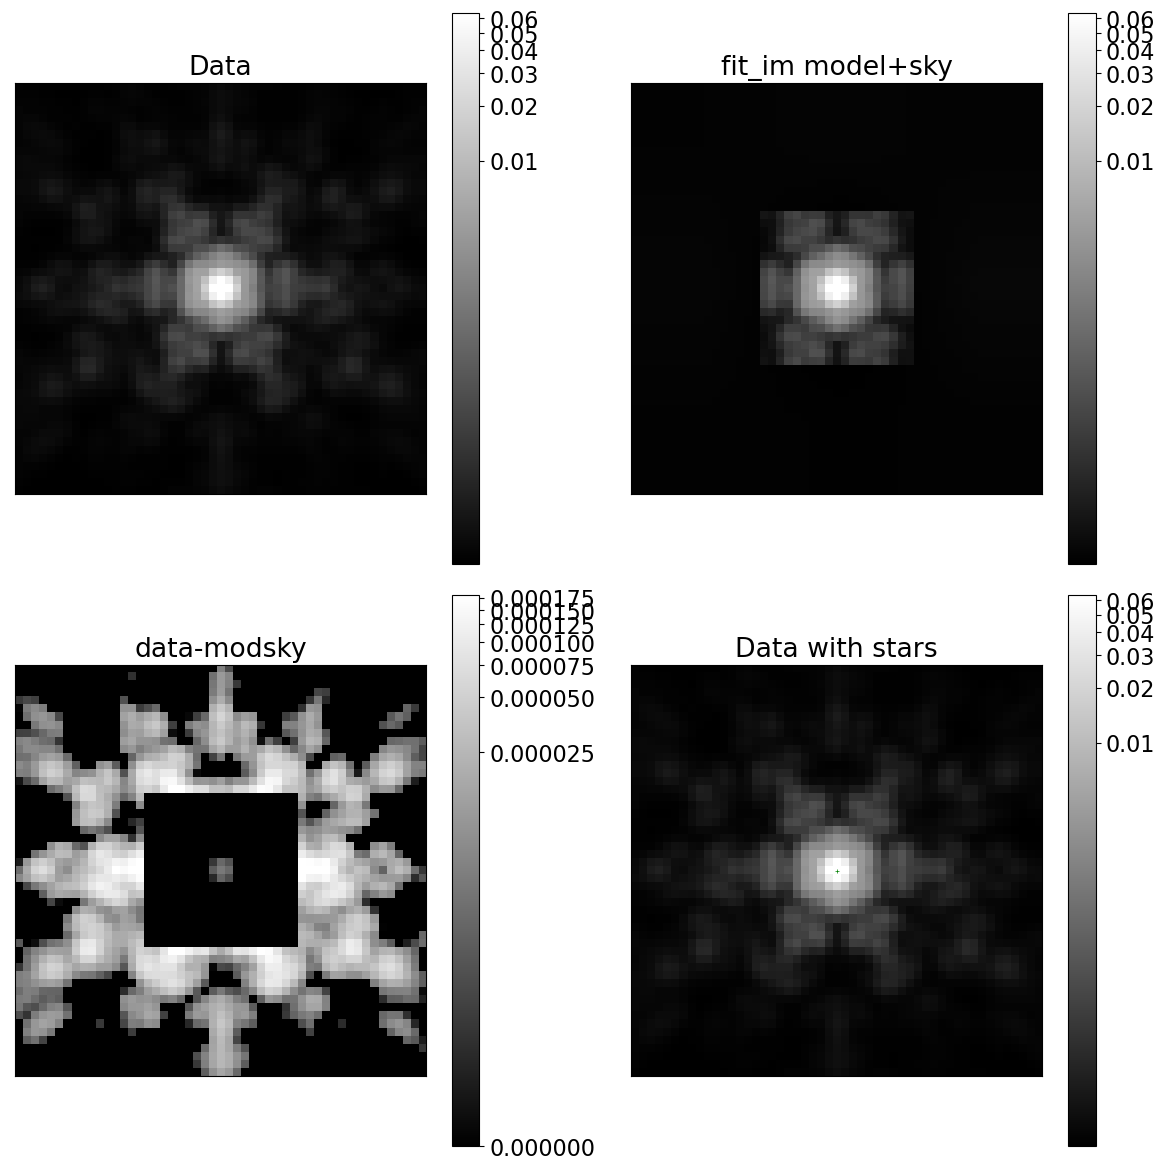

In [135]:
catalog_zoom_diagnostic(im, modsky_, (slice(None), slice(None)), Table(stars))

## Experiment 3: Fit blurred with oversampled, blurred, high S/N


In [150]:
import importlib
import crowdsource_catalogs_long
importlib.reload(crowdsource_catalogs_long)
from crowdsource_catalogs_long import WrappedPSFModel, get_psf_model, fit_im, catalog_zoom_diagnostic

2024-06-27T14:49:11.041497: Starting crowdsource_catalogs_long
2024-06-27T14:49:11.043780: Importing webbpsf
2024-06-27T14:49:11.044502: Done with imports


(0.09480662989226857, 0.9999999999999999)

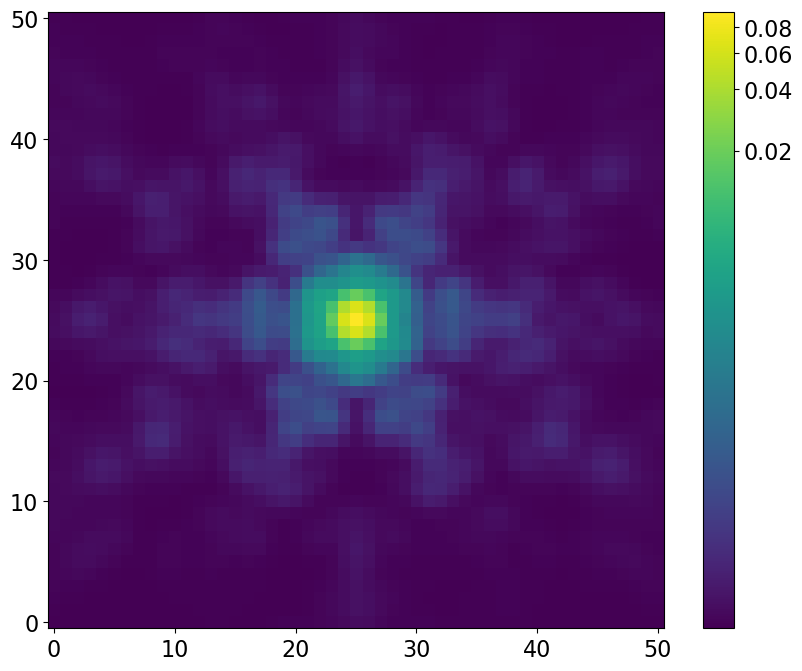

In [154]:
grid_, psf_for_crowdsource_blur_oversample = get_psf_model(filtername='f410m', proposal_id='2221', field='001', stampsz=51,
                                                           oversample=2, blur=True)
oversamp = psf_for_crowdsource_blur_oversample(25, 25)
pl.imshow(oversamp, norm=simple_norm(oversamp, stretch='log'));
pl.colorbar();
oversamp.max(), oversamp.sum()

In [155]:
# Experiment 3: 
im = psf_for_crowdsource_blur(25, 25)
stars, modsky_, skymsky_, psf_ = fit_im(im, psf=psf_for_crowdsource_blur_oversample, weight=np.ones_like(im) * 20001 / im.max())

#crowdsource backward [this is modified in save_crowdsource_results]
stars['x'], stars['y'] = stars['y'], stars['x']
Table(stars)

x,y,flux,passno,dx,dy,dflux,qf,rchi2,fracflux,fluxlbs,dfluxlbs,fwhm,spread_model,dspread_model,fluxiso,xiso,yiso,sky
float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32
25.000448296291456,25.000448296291456,0.93059087,0.0,4.9865146e-05,4.986826e-05,2.3657707e-05,1.0,18452.368474828036,1.0,0.9314353,2.4510828e-05,3.308183,-0.00067576738086772,1.1069553840974e-06,0.9305908,4.409990443596266e-06,2.733373078387135e-05,-3.3767844e-06


2024-06-27T14:49:57.673990: -0.0007249786141490348 False <astropy.visualization.mpl_normalize.ImageNormalize object at 0x1549d420c370>


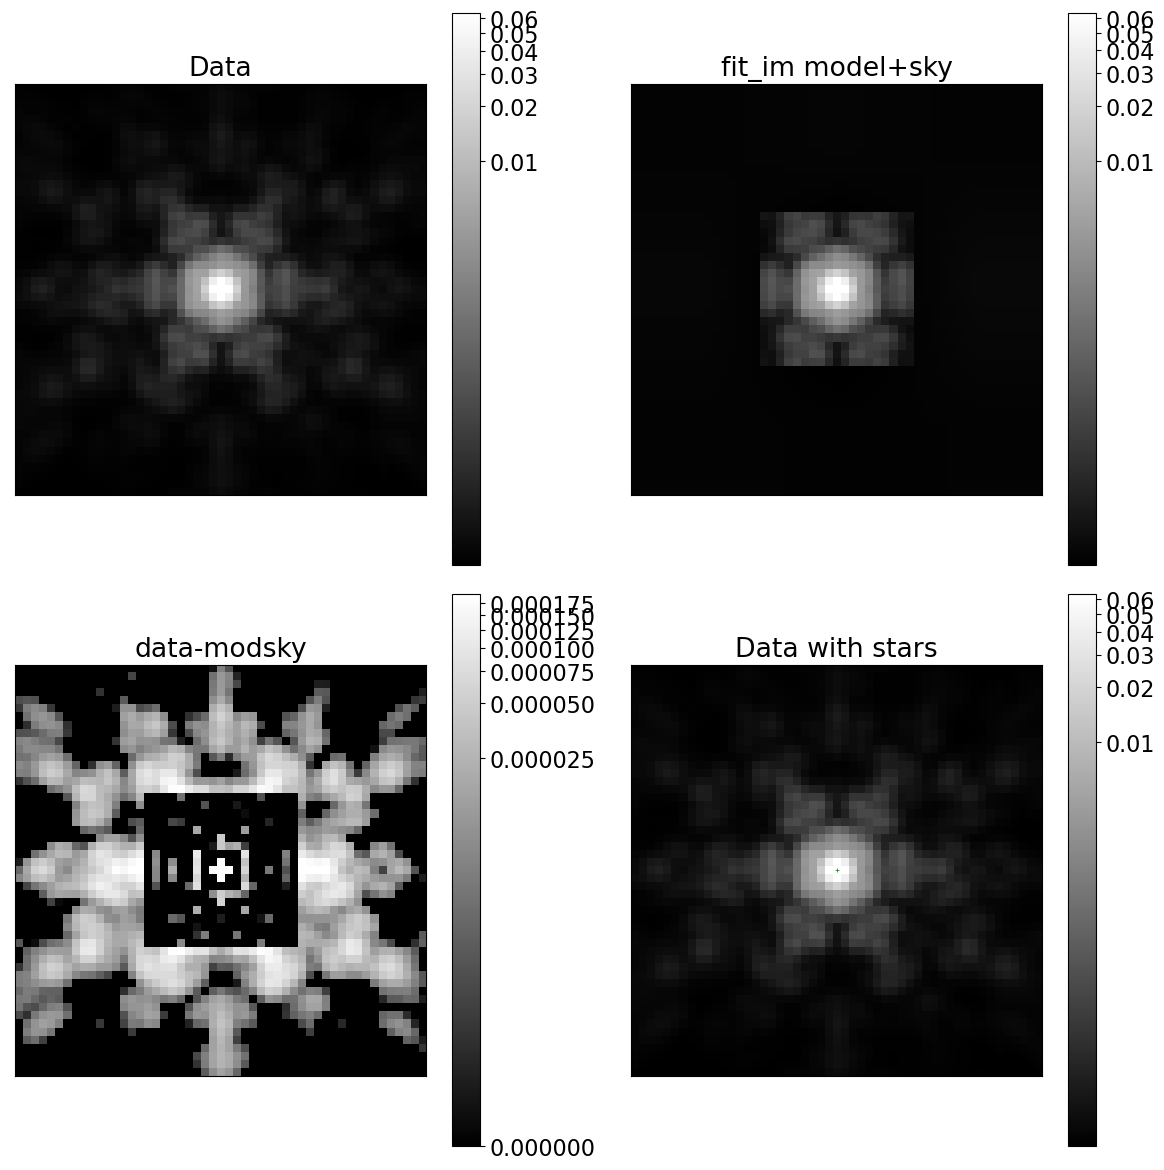

In [156]:
catalog_zoom_diagnostic(im, modsky_, (slice(None), slice(None)), Table(stars))